In [192]:
%matplotlib inline

import os
import pandas as pd
import tqdm
import networkx as nx

from scipy import interpolate
from scipy.stats import erlang
from scipy.integrate import odeint

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib import cm
from sklearn.linear_model import LinearRegression
import pickle

def init_fig(aspect=(4,4),fontsize=12):
    plt.rc('font', family='serif')
    plt.rc('xtick', labelsize=fontsize)
    plt.rc('ytick', labelsize=fontsize)
    plt.rc('figure', titlesize=fontsize)
    plt.rc('axes', labelsize=fontsize)
    plt.rc('axes', titlesize=fontsize)
    params = {'legend.fontsize': 'larger',
              'legend.handlelength': 2}
    plt.rcParams.update(params)

    fig = plt.figure(figsize=aspect)
    ax = fig.add_subplot(1, 1, 1)
    return ax,fig




In [4]:
def graph_run(G,config,period=14,lockdown=4,tmax=30*4,INIT_NUM=50,LOCKDOWN_RESCALING=1,DAY_RES=4):
    
    dt = 1/DAY_RES
    ERLANG_SHAPE = 2
    weight_attr='weight_const'
    
    E = set([list(G.nodes())[i] for i in np.random.choice(range(len(list(G.nodes()))),int(INIT_NUM/2))])
    S = set(list(G.nodes())).difference(E)
    I = set([list(S)[i] for i in np.random.choice(range(len(list(S))),int(INIT_NUM/2))])
    S = S.difference(I)
    R = set()
    
    EXPOSE_TIME = dict()
    INFECT_TIME = dict()
    
    infected_map = dict([(i,[]) for i in G.nodes()])
    infected_times = dict()
    
    for e in E:
        EXPOSE_TIME[e] = -1+erlang.rvs(a=ERLANG_SHAPE,scale=config["Tinc"]/ERLANG_SHAPE)
    
    for i in I:
        INFECT_TIME[i] = -1+erlang.rvs(a=ERLANG_SHAPE,scale=config["Tinf"]/ERLANG_SHAPE)
        infected_times[i] = -1
    
    sol=[]
    for day in np.linspace(1,tmax,tmax*DAY_RES):
        sol.append(np.array([len(x) for x in (S,E,I,R)]))
        
        I_new = set()
        E_new = set()
        R_new = set()
        
        # new infecting
        for e in E:
            if EXPOSE_TIME[e]-day <= 0:
                I_new.add(e)
                infected_times[e] = day
                INFECT_TIME[e] = day + erlang.rvs(a=ERLANG_SHAPE,scale=config["Tinf"]/ERLANG_SHAPE)
                
        for i in I:
            in_isolation = (((day%period) < lockdown))
            
            # new exposed 
            for neighbor in G.neighbors(i):
                if in_isolation and not G.get_edge_data(i,neighbor)['lockdown_neighbor']:
                    continue
                
                if neighbor in S:
                    infection_rate = G.get_edge_data(i,neighbor)[weight_attr]
                    if in_isolation:
                        infection_rate *= LOCKDOWN_RESCALING
                    if np.random.rand() < dt*infection_rate:
                        # infect
                        E_new.add(neighbor)
                        infected_map[i].append({"n" : neighbor, "t" : day})
                        EXPOSE_TIME[neighbor] = day + erlang.rvs(a=ERLANG_SHAPE,scale=config["Tinc"]/ERLANG_SHAPE)
            # new recovered
            if INFECT_TIME[i]-day <=0:
                R_new.add(i)

                
        S = S.difference(E_new)
        E = E.union(E_new).difference(I_new)
        I = I.union(I_new).difference(R_new)
        R = R.union(R_new)
    
        
    sol.append(np.array([len(x) for x in (S,E,I,R)]))
    #[infected_map.pop(i) for i in list(infected_map.keys()) if i not in R] 
    df = pd.DataFrame([({"node": i,
                         "infections" : len(infected_map[i]),
                         "infected" : infected_times[i] if i in infected_times.keys() else np.NaN,
                         'recovered' : i in R}) for i in infected_map.keys()]).set_index('node')
    
    sol = sol[::DAY_RES]
    return np.array(sol),df

def lognormal_adj(sigma,size):
    return np.random.lognormal(0,sigma,size=size)/np.exp((sigma**2)/2)


def load_small_world_graph(config,N = 2000,Rw=1.5,Rl=0.6):
    k = config["k"]
    beta=1-Rl/Rw
    G = nx.watts_strogatz_graph(N,k,beta)
    
    attrs = dict()
    tot_edges = len(G.edges())
    tot_nodes = len(G.nodes())
    
    
    edge_scalars=lognormal_adj(config["edge_sigma"],tot_edges)
    node_scalars=lognormal_adj(config["node_sigma"],tot_nodes)
    
    for edge,edge_scale in zip(G.edges(),edge_scalars):
        attrs[edge] = {"weight_const" : node_scalars[edge[0]]*edge_scale*Rw/(k*config["Tinf"]),
                       "lockdown_neighbor" : np.abs(edge[0]-edge[1]) <= k/2}
    nx.set_edge_attributes(G,attrs)    
    
    return G

In [159]:
def estimate_Re_percenteighty(config,T_relevant,Rw,Rl,period,lockdown,iterations=100):
    def record_infection_first_T_days(T):
        G = load_small_world_graph(config,Rw=Rw,Rl=Rl)
        sol,infection_log=graph_run(G,config,period=period,lockdown=lockdown,INIT_NUM=50,tmax=T+15,LOCKDOWN_RESCALING=1)
        infection_log=infection_log[infection_log.recovered]
        return infection_log[(infection_log.infected > -1) & (infection_log.infected < T-1)].infections

    infections=pd.concat([record_infection_first_T_days(T_relevant) for i in range(iterations)])
    percent_eighty = np.abs(((infections.sort_values().cumsum()[::-1] / infections.sum())-.2).values).argmin() / infections.shape[0]
    Re=infections.mean()
    return Re,percent_eighty


In [220]:
@np.vectorize
def k_sensitivity(k):
    print(k)
    config = {'Tinc': 3,'Tinf': 4,"edge_sigma" : 0,"node_sigma" : 0,"k" : int(k)}
    Re,_ = estimate_Re_percenteighty(config,T_relevant=14,Rw=1.5,Rl=0.6,period=14,lockdown=10,iterations=250)
    return Re

In [225]:
kvals = np.linspace(20,100,3)
out = k_sensitivity(kvals)

20.0
20.0
60.0
100.0


In [228]:
config = {'Tinc': 3,'Tinf': 4,"edge_sigma" : 0,"node_sigma" : 0,"k" : 50}
Re,_ = estimate_Re_percenteighty(config,T_relevant=14,Rw=1.5,Rl=0.6,period=14,lockdown=10,iterations=250)


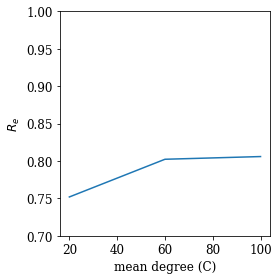

In [229]:
tck=interpolate.splrep(kvals, out, s=1,k=2)
xnew=np.linspace(kvals.min(),kvals.max(),100)
ynew = interpolate.splev(xnew, tck, der=0)

ax,fig=init_fig(aspect=(4,4))
ax.plot(kvals,out)
#plt.plot(xnew,ynew)
ax.set_ylabel("$R_e$")
ax.set_xlabel("mean degree (C)")
ax.set_ylim((.7,1))
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR,"plots","sensitivity_degree.pdf"))

In [234]:
def run_over_sigmas(pars,iterations=500):
    out = []
    for sigma,for_node,Rw,Rl in pars:
        print(sigma)
        edge_sigma,node_sigma = (0,sigma) if for_node else (sigma,0)
        config = {'Tinc': 3,'Tinf': 4,"node_sigma" :node_sigma,"edge_sigma" : edge_sigma,"k" : 50}
        mu_,sigma_=np.exp((sigma**2)/2),np.sqrt((np.exp((sigma**2))-1)*np.exp((sigma**2)))
        cv = sigma_/mu_
        print(config)
        Re,pe = estimate_Re_percenteighty(config,T_relevant=14,Rw=Rw,Rl=Rl,period=14,lockdown=10,iterations=iterations)
        out.append([cv,Re,pe])

    out = np.array(out)
    return out

In [235]:
def gen_dist_plot(out,nodes="",label=""):
    tck=interpolate.splrep(out[:,0], out[:,1], s=1,k=2)
    xnew = np.linspace(out[:,0].min(),out[:,0].max(), 100)
    ynew = interpolate.splev(xnew, tck, der=0)

    ax,fig=init_fig(aspect=(4,4))
    ax.plot(out[:,0],out[:,1])
    ax.set_ylabel("$R_e$")
    ax.set_xlabel(label)
    ax.set_ylim((.7,1))
    plt.tight_layout()
    plt.savefig(os.path.join(BASE_DIR,"plots","sensitivity_dist_lognormal_{nodes}.pdf".format(nodes=nodes)))
    
    ax,fig=init_fig(aspect=(3,2),fontsize=14)
    ax.plot(out[:,0],100*out[:,2])
    ax.set_ylabel("percent")
    ax.set_title("resp. for 80% infections")
    ax.set_xlabel(label)
    ax.set_ylim((10,40))
    fig.tight_layout()
    plt.savefig(os.path.join(BASE_DIR,"plots","sensitivity_dist_lognormal_{nodes}_eighty.pdf".format(nodes=nodes)))
    #plt.yscale('log')

In [240]:
out = run_over_sigmas(((0,True,1.5,0.6),(1,True,1.355,.54),(2,True,1.1,.43)))

0
{'Tinc': 3, 'Tinf': 4, 'node_sigma': 0, 'edge_sigma': 0, 'k': 50}
1
{'Tinc': 3, 'Tinf': 4, 'node_sigma': 1, 'edge_sigma': 0, 'k': 50}
2
{'Tinc': 3, 'Tinf': 4, 'node_sigma': 2, 'edge_sigma': 0, 'k': 50}


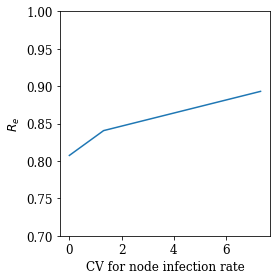

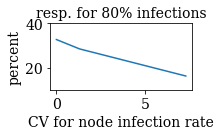

In [242]:
gen_dist_plot(out,"nodes","CV for node infection rate")

In [236]:
out = run_over_sigmas(((0,False,1.5,0.6),(1,False,1.6,.6),(2,False,2.2,.74)))

0
{'Tinc': 3, 'Tinf': 4, 'node_sigma': 0, 'edge_sigma': 0, 'k': 50}
1
{'Tinc': 3, 'Tinf': 4, 'node_sigma': 0, 'edge_sigma': 1, 'k': 50}
2
{'Tinc': 3, 'Tinf': 4, 'node_sigma': 0, 'edge_sigma': 2, 'k': 50}


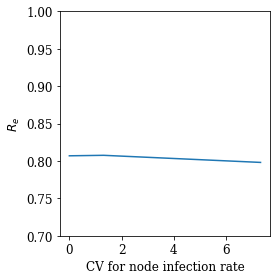

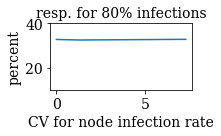

In [239]:
gen_dist_plot(out,"","CV for node infection rate")